In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy_indexed as npi
from labellines import labelLines
import os
import sys

'''
Script to compare cas and stability setup JV scan pixel by pixel
replace file path below

'''

# cas_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\photodiodetest\cas_analyzed\0\Data\photo - 0p_0.0Sun_Scan0.txt"
# ss_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\photodiodetest\0p\Nov-08-2023 15_57_40lightID1scan.csv"



'\nScript to compare cas and stability setup JV scan pixel by pixel\nreplace file path below\n\n'

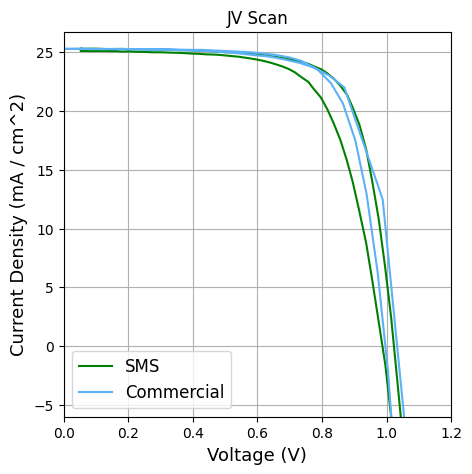

C:\Users\achen\AppData\Local\Temp\ipykernel_49788\3560975384.py:451: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_plot_data_ff, labels=labels_ff)


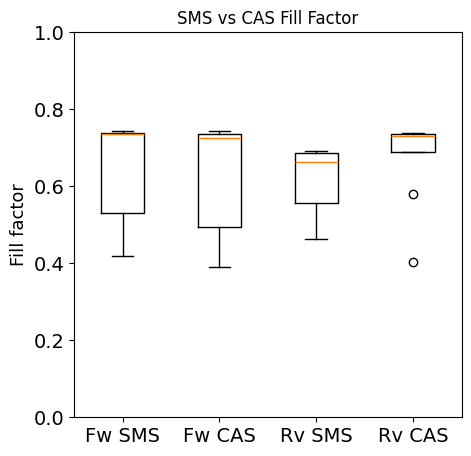

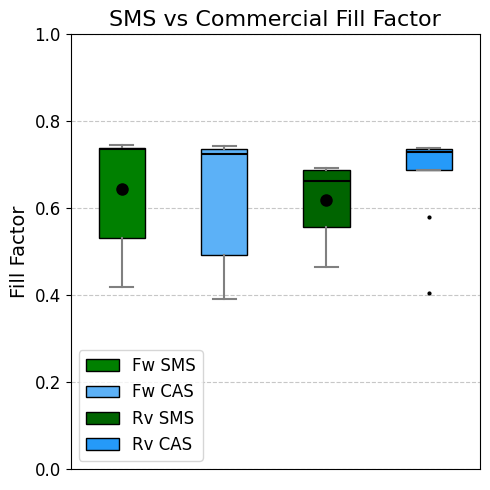

C:\Users\achen\AppData\Local\Temp\ipykernel_49788\3560975384.py:471: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_plot_data_voc, labels=labels_voc)


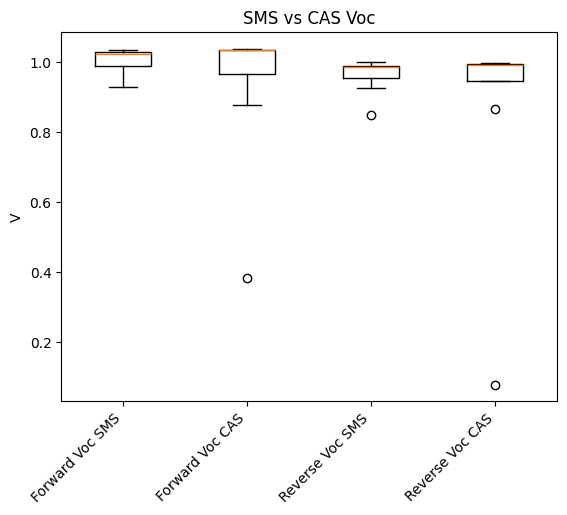

C:\Users\achen\AppData\Local\Temp\ipykernel_49788\3560975384.py:478: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_plot_data_jsc, labels=labels_jsc)


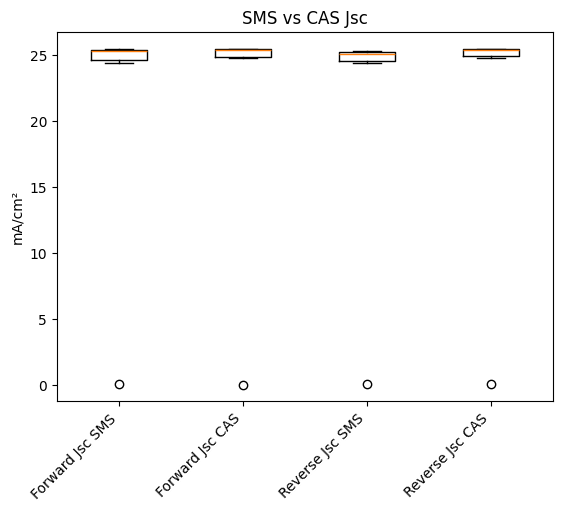

Total Average FF diff (% fill factor) = 0.030044642168962295
Total Average VOC diff (V)= 0.01498183435017747
Total Average JSC diff (mA/cm²)= 0.18754183456293308
Total Average PCE diff (% PCE)= 0.9014743319782863
Total Average FF diff Raw (% fill factor)= -0.010490800814346378
Total Average VOC diff Raw (V)= 0.005655683748168883
Total Average JSC diff Raw (mA/cm²)= -0.1830641616052477
Total Average PCE diff Raw (% PCE)= -0.35777048328571415


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import numpy_indexed as npi
from labellines import labelLines
from matplotlib.font_manager import FontProperties
np.set_printoptions(linewidth=100)   # or pick a big number, e.g. 200
import os
import sys
import re
from scipy.interpolate import interp1d	 # pip install scipy

# def get_stats_arr(voltage, current):


def get_stats(voltage, current):
    ff_all = []
    jsc_all = []
    voc_all = []
    pce_all = []
    for i in range(voltage.shape[1]):
        V = np.asarray(voltage[:, i])
        I = np.asarray(current[:, i])
        if V.shape != I.shape:
            raise ValueError("voltages and currents must have the same shape")

        # 1) Voc: interpolate V at I=0
        #    Sort by current for reliable interpolation
        sort_I = np.argsort(I)
        I_sorted = I[sort_I]
        V_sorted_by_I = V[sort_I]
        Voc = float(np.interp(0.0, I_sorted, V_sorted_by_I))

        # 2) Isc: interpolate I at V=0
        sort_V = np.argsort(V)
        V_sorted = V[sort_V]
        I_sorted_by_V = I[sort_V]
        Isc = float(np.interp(0.0, V_sorted, I_sorted_by_V))

        # 3) Maximum power point
        P = V * I
        idx_mp = np.argmax(P)
        Vmp = float(V[idx_mp])
        Imp = float(I[idx_mp])

        # 4) Fill Factor
        FF = (Vmp * Imp) / (Voc * Isc) if (Voc * Isc) != 0 else np.nan

        pce = (Vmp * Imp) / 100 * 100

        ff_all.append(FF)
        jsc_all.append(Isc)
        voc_all.append(Voc)
        pce_all.append(pce)

    return {
        "FF":  np.array(ff_all),
        "PCE": np.array(pce_all),
        "Jsc": np.array(jsc_all),
        "Voc": np.array(voc_all)
    }
from matplotlib.patches import Patch

def create_styled_boxplot(data_list, labels, title, ylabel, output_filename="styled_boxplot.png", figsize=(8, 10)):
    """
    Creates and saves a styled box plot similar to the provided example image.

    Args:
        data_list (list): A list of NumPy arrays or lists, where each element is a dataset for a box.
        labels (list): A list of strings for the x-axis labels.
        title (str): The title for the plot.
        ylabel (str): The label for the y-axis.
        output_filename (str): The name of the file to save the plot.
        figsize (tuple): The size of the figure.
    """
    # Define a color palette. You can customize this.
    colors = ['green', '#5CB1F7', 'darkgreen', "#259AF9"]

    fig, ax = plt.subplots(figsize=figsize)

    # --- Main Boxplot Creation ---
    bp = ax.boxplot(data_list,
                    patch_artist=True,      # Crucial for filling boxes with color
                    # labels=labels,
                    showmeans=True,         # Shows the mean value as a point
                    flierprops=dict(marker='.', markerfacecolor='black', markersize=4, linestyle='none'),
                    meanprops=dict(marker='o', markerfacecolor='black', markeredgecolor='black', markersize=8),
                    medianprops=dict(color='black', linewidth=1.5)
                   )

    # --- Styling the Plot ---
    # Set the y-axis to a logarithmic scale (a key feature of the example)
    # ax.set_yscale('log')
    # You may need to adjust the y-limits based on your data's range
    # ax.set_ylim(10**-3, 10**3)

    # Set custom colors for each box
    for i, box in enumerate(bp['boxes']):
        box.set_facecolor(colors[i % len(colors)]) # Cycle through colors if not enough
        box.set_edgecolor('black')

    # Style whiskers and caps to be gray
    for whisker, cap in zip(bp['whiskers'], bp['caps']):
        whisker.set(color='gray', linewidth=1.5)
        cap.set(color='gray', linewidth=1.5)

    # --- Labels, Title, and Grid ---
    ax.set_title(title, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.tick_params(axis='x', labelrotation=45)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7, which='both')

    # --- Custom Legend ---
    # This is needed because a standard legend doesn't work well with boxplots
    legend_elements = [Patch(facecolor=colors[i % len(colors)], edgecolor='black', label=labels[i]) for i in range(len(labels))]
    ax.legend(handles=legend_elements, loc='best', fontsize=12)
    ax.tick_params(axis='x', bottom=False)
    ax.set_ylim(0, 1)
    ax.set_xticklabels([])

    # --- Save and Show ---
    plt.tight_layout()
    plt.savefig(output_filename, dpi=300) # Save with high resolution
    plt.show()

def plot_difference(ss_file_path, cas_directory, cas_str, plot_size,pixels_to_plot, roll = 0):
    # cas_directory = ""
    # cas_directory = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-4-2025 4 device test\2025-03-04-- cas New PCB 4 Device comparison\devices\device_2"
    np.set_printoptions(threshold=np.inf)
    data = []
    cell_area = 0
    # ss_file_path = ""
    # ss_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-4-2025 4 device test\Mar-04-2025 16_42_19__4 Device First Test\Mar-04-2025_16-44-53__4 Device First Test__ID2__mppt.csv"
    if ss_file_path != "":
        arr = np.loadtxt(ss_file_path, delimiter=",", dtype=str)
        header_row = np.where(arr == "Time")[0][0]

        meta_data = {}
        for data in arr[:header_row, :2]:
            meta_data[data[0]] = data[1]

        headers = arr[header_row, :]
        arr = arr[header_row + 1 :, :]

        data = arr[:, 2:-1]
        cell_area = float(meta_data["Cell Area (mm^2)"])
        pixel_V = data[:, ::2][:, ::-1].astype(float)
        pixel_mA = data[:, 1::2][:, ::-1].astype(float) / float(meta_data["Cell Area (mm^2)"])
        # if ("Cell Area (mm^2)" in meta_data):
        #	 pixel_mA /= float(meta_data["Cell Area (mm^2)"])
        # else:
        #	 pixel_mA /= 0.128

    all_files = []

    if cas_directory != "":
        # print(cas_directory)
        for root, dirs, files in os.walk(cas_directory):
            for file in files:
                if file.endswith('.csv'):
                    file_path = os.path.join(root, file)
                    all_files.append(file_path)

    cas_voltage = []
    cas_current = []

    # Process each file
    for file_path in all_files:
        if cas_str in file_path:
            try:
                data = np.genfromtxt(
                    file_path,
                    delimiter=',',
                    comments='#',
                    skip_header=0,
                    encoding='cp1252'  # Specify the correct encoding
                )
                voltage = data[:, 0]
                current = data[:,1]

                mask		   = np.isfinite(voltage) & np.isfinite(current)
                voltage_clean  = voltage[mask]
                current_clean  = current[mask]/cell_area

                cas_voltage.append(voltage_clean)
                cas_current.append(current_clean)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    cas_voltage = np.array(cas_voltage).T
    cas_current = np.array(cas_current).T


    # ax.spines['bottom'].set_position(('data', 0))

    ss_half = pixel_V.shape[0] // 2
    cas_half = cas_voltage.shape[0] // 2

    cas_Fv = cas_voltage[:cas_half,:]
    cas_Fa = cas_current[:cas_half,:]
    results = get_stats(cas_Fv, cas_Fa)
    ff_cas_fw = results["FF"]
    jsc_cas_fw = results["Jsc"]
    voc_cas_fw = results["Voc"]
    pce_cas_fw = results["PCE"]

    cas_Rv = cas_voltage[cas_half:,:]
    cas_Ra = cas_current[cas_half:,:]
    results = get_stats(cas_Rv, cas_Ra)
    ff_cas_rv = results["FF"]
    jsc_cas_rv = results["Jsc"]
    voc_cas_rv = results["Voc"]
    pce_cas_rv = results["PCE"]

    sms_Fv = pixel_V[ss_half:,:]
    sms_Fa = pixel_mA[ss_half:,:]
    results = get_stats(sms_Fv, sms_Fa)
    ff_sms_fw = results["FF"]
    jsc_sms_fw = results["Jsc"]
    voc_sms_fw = results["Voc"]
    pce_sms_fw = results["PCE"]


    sms_Rv = pixel_V[:ss_half,:]
    sms_Ra = pixel_mA[:ss_half,:]
    results = get_stats(sms_Rv, sms_Ra)
    ff_sms_rv = results["FF"]
    jsc_sms_rv = results["Jsc"]
    voc_sms_rv = results["Voc"]
    pce_sms_rv = results["PCE"]

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    plt.figure(figsize=(plot_size))
    plt.xlim(0,1.2)
    top = max(np.max(pixel_mA), np.max(current))*1.05
    plt.ylim(bottom = -6, top = top)
    plt.xlabel('Voltage (V)', fontsize=13)
    plt.ylabel('Current Density (mA / cm^2)',  fontsize=13)
    plt.grid()
    ax = plt.gca()

    for i in pixels_to_plot:
        # plt.title(f"Pixel{i}")

        lineName = "SMS"
        if ss_file_path:
            plt.plot(pixel_V[:,i],
                     pixel_mA[:,i],
                    #  linestyle='--',
                     color='green',
                     label = lineName)
        if True:
            # plt.hlines(pce[i], x_start, x_end, label="cas_pce" + str(i + 1))
            plt.plot(cas_voltage[:,i],
                     cas_current[:,i],
                     color="#5CB1F7",
                     label = "Commercial")

        # print(f"cas forward:{ff_cas_f[i]}")
        # print(f"sms forward:{ff_sms_f[i]}")
        # print(f"cas reverse:{ff_cas_R[i]}")
        # print(f"sms reverse:{ff_sms_R[i]}")

        # plt.legend(bbox_to_anchor=(0.25, 0.16))
    plt.title("JV Scan")
    plt.legend(fontsize=12, loc='best')
    plt.savefig(
            "JV_Plot.png",         # output filename (extension defines format)
        )
    plt.show()


    ff_diff_forward = np.abs(ff_sms_fw - ff_cas_fw)
    ff_diff_reverse = np.abs(ff_sms_rv - ff_cas_rv)
    voc_diff_forward = np.abs(voc_sms_fw - voc_cas_fw)
    voc_diff_reverse = np.abs(voc_sms_rv - voc_cas_rv)
    jsc_diff_forward = np.abs(jsc_sms_fw - jsc_cas_fw)
    jsc_diff_reverse = np.abs(jsc_sms_rv - jsc_cas_rv)
    pce_diff_forward = np.abs(pce_sms_fw - pce_cas_fw)
    pce_diff_reverse = np.abs(pce_sms_rv - pce_cas_rv)

    diff_forward_raw  = ff_sms_fw - ff_cas_fw
    diff_reverse_raw  = ff_sms_rv - ff_cas_rv
    ff_diff_raw = np.concatenate((diff_forward_raw, diff_reverse_raw))

    voc_raw_forward   =  voc_sms_fw - voc_cas_fw
    voc_raw_reverse   =  voc_sms_rv - voc_cas_rv
    voc_diff_raw      = np.concatenate((voc_raw_forward, voc_raw_reverse))

    jsc_raw_forward   =  jsc_sms_fw - jsc_cas_fw
    jsc_raw_reverse   =  jsc_sms_rv - jsc_cas_rv
    jsc_diff_raw      = np.concatenate((jsc_raw_forward, jsc_raw_reverse))

    pce_raw_forward = pce_sms_fw - pce_cas_fw
    pce_raw_reverse = pce_sms_rv - pce_cas_rv
    pce_diff_raw      = np.concatenate((pce_raw_forward, pce_raw_reverse))


    box_plot_data_ff = [ff_sms_fw, ff_cas_fw,ff_sms_rv, ff_cas_rv]

    box_plot_data_voc = [voc_sms_fw, voc_cas_fw, voc_sms_rv, voc_cas_rv]

    box_plot_data_jsc = [jsc_sms_fw, jsc_cas_fw, jsc_sms_rv, jsc_cas_rv]

    box_plot_data_pce = [pce_sms_fw, pce_cas_fw, pce_sms_rv, pce_cas_rv]

    result_dict = {
        'ff_diff_forward': ff_diff_forward,
        'voc_diff_forward': voc_diff_forward,
        'ff_diff_reverse': ff_diff_reverse,
        'voc_diff_reverse': voc_diff_reverse,
        'jsc_diff_forward': jsc_diff_forward,
        'jsc_diff_reverse': jsc_diff_reverse,
        'pce_diff_forward': pce_diff_forward,
        'pce_diff_reverse': pce_diff_reverse,
        'box_plot_data_ff': box_plot_data_ff,
        'box_plot_data_voc': box_plot_data_voc,
        'box_plot_data_jsc': box_plot_data_jsc,
        'box_plot_data_pce': box_plot_data_pce,
        'ff_diff_raw': ff_diff_raw,
        'voc_diff_raw': voc_diff_raw,
        'jsc_diff_raw': jsc_diff_raw,
        'pce_diff_raw': pce_diff_raw
    }

    return result_dict

files = []
# for i in range(1,5):
# 	files.append([
# 		rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\April-03-2025 cas\devices\{i}",
# 		rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_18_09\Apr-03-2025_19-18-19__ID{i}__light__scan.csv"
# 	])

r"""
Best performing
for i in range(4,5):

for i in range(4,5):
    files.append([
        rf"C:\Users\Andrew Chen\Dropbox\code\Stability-Setup\data\Apr-10-2025 18_28_52\cas\devices\{i}",
        rf"C:\Users\Andrew Chen\Dropbox\code\Stability-Setup\data\Apr-10-2025 18_28_52\Apr-10-2025_18-39-43__ID{i}__light__scan.csv"
    ])

"""

# Trial with CAS holder
sms_files = [
	# rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_41_27\Apr-03-2025_19-41-45__ID1__light__scan.csv",
	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_41_27\Apr-03-2025_19-41-45__ID2__light__scan.csv",
	# rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_41_27\Apr-03-2025_19-41-45__ID3__light__scan.csv",
	# rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_41_27\Apr-03-2025_19-41-45__ID4__light__scan.csv",
]
cas_files = [
	# rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_41_27\devices\1",
	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_41_27\devices\2",
	# rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_41_27\devices\3",
	# rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_41_27\devices\4",
]

# Trial with SMS sample holder
# sms_files = [
#     rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\Apr-29-2025_17-26-38__ID1__light__scan.csv",
#     rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\Apr-29-2025_17-32-23__ID2__light__scan.csv",
#     rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\Apr-29-2025_17-32-23__ID3__light__scan.csv",
#     rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\Apr-29-2025_17-26-38__ID4__light__scan.csv",
# ]
# cas_files = [
#     rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\devices\1",
#     rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\devices\2",
#     rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\devices\3",
#     rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\devices\4",
# ]

for sms, cas in zip(sms_files, cas_files):
    files.append([
     sms,
     cas
    ])

all_ff_diff = []
all_ff_diff_raw = []
all_voc_diff = []
all_voc_diff_raw = []
all_jsc_diff = []
all_jsc_diff_raw = []
all_pce_diff = []
all_pce_diff_raw = []
box_plot_data_voc = [[],[],[],[]]
box_plot_data_ff = [[],[],[],[]]
box_plot_data_jsc = [[],[],[],[]]
box_plot_data_pce = [[],[],[],[]]
pixels_to_plot=[2]
for ss_file, cas in files:
    results = plot_difference(ss_file, cas, "_4_0", (5,5),pixels_to_plot)
    # print(np.argsort(ff_diffs_forward))
    # print(np.argsort(ff_diffs_reverse))
    # print(np.argsort(voc_diffs_forward))
    # print(np.argsort(voc_diffs_reverse))

    # print(f"FF diff foward {np.mean(ff_diff_forward)}, FF diff Reverse{np.mean(ff_diff_reverse)}")
    # print(f"voc diff forward {np.mean(voc_diff_forward)}, voc diff reverse {np.mean(voc_diff_reverse)}")

    all_ff_diff.extend(results["ff_diff_forward"])
    all_ff_diff.extend(results["ff_diff_reverse"])
    all_voc_diff.extend(results["voc_diff_forward"])
    all_voc_diff.extend(results["voc_diff_reverse"])
    all_jsc_diff.extend(results["jsc_diff_forward"])
    all_jsc_diff.extend(results["jsc_diff_reverse"])
    all_pce_diff.extend(results["pce_diff_forward"])
    all_pce_diff.extend(results["pce_diff_reverse"])


    all_ff_diff_raw.extend(results["ff_diff_raw"])
    all_voc_diff_raw.extend(results["voc_diff_raw"])
    all_jsc_diff_raw.extend(results["jsc_diff_raw"])
    all_pce_diff_raw.extend(results["pce_diff_raw"])

    for i in range(4):
        box_plot_data_voc[i].extend(results["box_plot_data_voc"][i])
        box_plot_data_ff[i].extend(results["box_plot_data_ff"][i])
        box_plot_data_jsc[i].extend(results["box_plot_data_jsc"][i])
        box_plot_data_pce[i].extend(results["box_plot_data_pce"][i])

all_ff_diff = np.asarray(all_ff_diff)
all_voc_diff = np.asarray(all_voc_diff)
all_jsc_diff = np.asarray(all_jsc_diff)
all_pce_diff = np.asarray(all_pce_diff)
mask = all_ff_diff <= 1
all_ff_diff_filtered = all_ff_diff[mask]
all_voc_diff_filtered = all_voc_diff[mask]
all_jsc_diff_filtered = all_jsc_diff[mask]
all_pce_diff_filtered = all_pce_diff[mask]

all_ff_diff_raw = np.asarray(all_ff_diff_raw)
all_voc_diff_raw = np.asarray(all_voc_diff_raw)
all_jsc_diff_raw = np.asarray(all_jsc_diff_raw)
all_pce_diff_raw = np.asarray(all_pce_diff_raw)
mask = (all_ff_diff_raw >= -1) & (all_ff_diff_raw <= 1)
all_ff_diff_raw_filtered = all_ff_diff_raw[mask]
all_voc_diff_raw_filtered = all_voc_diff_raw[mask]
all_jsc_diff_raw_filtered = all_jsc_diff_raw[mask]
all_pce_diff_raw_filtered = all_pce_diff_raw[mask]

labels_ff = ['Fw SMS', 'Fw CAS',
             'Rv SMS', 'Rv CAS']

FIGSIZE = (5, 5)     # e.g. 8.6 cm × 6.6 cm  (single-column width)
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.boxplot(box_plot_data_ff, labels=labels_ff)


# ax.set_xticklabels(labels_ff, rotation=45, ha='right')
ax.tick_params(axis='both', which='major', labelsize=14)

ax.set_title("SMS vs CAS Fill Factor")
ax.set_ylabel("Fill factor", fontsize=13)		  # “V” → probably “–” for dimensionless FF

# —-------------------------------------
ax.set_ylim(0, 1)   # <-- change the numbers to whatever bounds you want
# —-------------------------------------

plt.savefig(
            "Comparison_FF_BoxPlot.png",         # output filename (extension defines format)
        )
plt.show()
create_styled_boxplot(box_plot_data_ff, labels_ff, "SMS vs Commercial Fill Factor", "Fill Factor", figsize=FIGSIZE)

labels_voc = ['Forward Voc SMS', 'Forward Voc CAS','Reverse Voc SMS','Reverse Voc CAS',]
plt.boxplot(box_plot_data_voc, labels=labels_voc)
plt.xticks(rotation=45, ha='right')  # Rotate labels diagonally
plt.title("SMS vs CAS Voc")
plt.ylabel("V")
plt.show()

labels_jsc = ['Forward Jsc SMS', 'Forward Jsc CAS','Reverse Jsc SMS','Reverse Jsc CAS',]
plt.boxplot(box_plot_data_jsc, labels=labels_jsc)
plt.xticks(rotation=45, ha='right')  # Rotate labels diagonally
plt.title("SMS vs CAS Jsc")
plt.ylabel("mA/cm²")
plt.show()

# print(box_plot_data_ff)
print(f"Total Average FF diff (% fill factor) = {np.mean(all_ff_diff_filtered)}")
print(f"Total Average VOC diff (V)= {np.mean(all_voc_diff_filtered)}")
print(f"Total Average JSC diff (mA/cm²)= {np.mean(all_jsc_diff_filtered)}")
print(f"Total Average PCE diff (% PCE)= {np.mean(all_pce_diff_filtered)}")
print(f"Total Average FF diff Raw (% fill factor)= {np.mean(all_ff_diff_raw_filtered)}")
print(f"Total Average VOC diff Raw (V)= {np.mean(all_voc_diff_raw_filtered)}")
print(f"Total Average JSC diff Raw (mA/cm²)= {np.mean(all_jsc_diff_raw_filtered)}")
print(f"Total Average PCE diff Raw (% PCE)= {np.mean(all_pce_diff_raw_filtered)}")


In [3]:
import numpy as np
from scipy import stats

bias = all_ff_diff_raw_filtered.mean()
mae = np.abs(all_ff_diff_raw_filtered).mean()
sd   = all_ff_diff_raw_filtered.std(ddof=1)
rmse = np.sqrt((all_ff_diff_raw_filtered**2).mean())
ci95 = stats.t.interval(0.95, len(all_ff_diff_raw_filtered)-1, loc=bias, scale=sd/np.sqrt(len(all_ff_diff_raw_filtered)))
loa  = (bias - 1.96*sd, bias + 1.96*sd)
ci95 = (round(ci95[0], 4), round(ci95[1], 4))
loa  = (round(loa[0],  4), round(loa[1],  4))

print(f"Fill factor bias = {bias:.4f}")
print(f"Fill factor mae   = {mae:.4f}")
print(f"Fill factor rmse = {rmse:.4f}")
print(f"Fill factor ci95 = {ci95}")
print(f"Fill factor loa  = {loa}")


bias = all_voc_diff_raw_filtered.mean()
mae = np.abs(all_voc_diff_raw_filtered).mean()
sd   = all_voc_diff_raw_filtered.std(ddof=1)
rmse = np.sqrt((all_voc_diff_raw_filtered**2).mean())
ci95 = stats.t.interval(0.95, len(all_voc_diff_raw_filtered)-1, loc=bias, scale=sd/np.sqrt(len(all_voc_diff_raw_filtered)))
loa  = (bias - 1.96*sd, bias + 1.96*sd)
ci95 = (round(ci95[0], 4), round(ci95[1], 4))
loa  = (round(loa[0],  4), round(loa[1],  4))

print(f"Voc bias = {bias:.4f}")
print(f"Voc mae   = {mae:.4f}")
print(f"Voc rmse = {rmse:.4f}")
print(f"Voc ci95 = {ci95}")
print(f"Voc loa  = {loa}")


bias = all_jsc_diff_raw_filtered.mean()
mae = np.abs(all_jsc_diff_raw_filtered).mean()
sd   = all_jsc_diff_raw_filtered.std(ddof=1)
rmse = np.sqrt((all_jsc_diff_raw_filtered**2).mean())
ci95 = stats.t.interval(0.95, len(all_jsc_diff_raw_filtered)-1, loc=bias, scale=sd/np.sqrt(len(all_jsc_diff_raw_filtered)))
loa  = (bias - 1.96*sd, bias + 1.96*sd)
ci95 = (round(ci95[0], 4), round(ci95[1], 4))
loa  = (round(loa[0],  4), round(loa[1],  4))

print(f"Jsc bias = {bias:.4f}")
print(f"Jsc mae   = {mae:.4f}")
print(f"Jsc rmse = {rmse:.4f}")
print(f"Jsc ci95 = {ci95}")
print(f"Jsc loa  = {loa}")


bias = all_pce_diff_raw_filtered.mean()
mae = np.abs(all_pce_diff_raw_filtered).mean()
sd   = all_pce_diff_raw_filtered.std(ddof=1)
rmse = np.sqrt((all_pce_diff_raw_filtered**2).mean())
ci95 = stats.t.interval(0.95, len(all_pce_diff_raw_filtered)-1, loc=bias, scale=sd/np.sqrt(len(all_pce_diff_raw_filtered)))
loa  = (bias - 1.96*sd, bias + 1.96*sd)
ci95 = (round(ci95[0], 4), round(ci95[1], 4))
loa  = (round(loa[0],  4), round(loa[1],  4))

print(f"pce bias = {bias:.4f}")
print(f"pce mae   = {mae:.4f}")
print(f"pce rmse = {rmse:.4f}")
print(f"pce ci95 = {ci95}")
print(f"pce loa  = {loa}")




Fill factor bias = -0.0221
Fill factor mae   = 0.0529
Fill factor rmse = 0.0694
Fill factor ci95 = (-0.0389, -0.0052)
Fill factor loa  = (-0.1522, 0.1081)
Voc bias = 0.0049
Voc mae   = 0.0158
Voc rmse = 0.0283
Voc ci95 = (-0.0022, 0.0121)
Voc loa  = (-0.0502, 0.06)
Jsc bias = -0.3306
Jsc mae   = 0.4229
Jsc rmse = 0.7264
Jsc ci95 = (-0.4962, -0.165)
Jsc loa  = (-1.6086, 0.9474)
pce bias = -0.7515
pce mae   = 1.3563
pce rmse = 1.6478
pce ci95 = (-1.1269, -0.376)
pce loa  = (-3.6492, 2.1463)


In [4]:

cas_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\photodiodetest\cas_analyzed\100\Data\photo - 100p_1.0Sun_Scan0.txt"
ss_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\photodiodetest\100p\Nov-08-2023 14_40_34lightID1scan.csv"

cas = np.loadtxt(cas_file_path,
                     delimiter="\t",
                     dtype=str)
cas = cas.T
cas = cas[:,1:].astype(float)

arr = np.loadtxt(ss_file_path,
                     delimiter=",",
                     dtype=str)
NUM_DEVICES = int((arr.shape[1]-2)/16)
device_to_pixels = {}
for i in range(NUM_DEVICES):
    device_to_pixels[i] = [j + 8*i for j in range(8)]

headers = arr[6,:]
header_dict = {value: index for index, value in enumerate(headers)}
arr = arr[7:, :]
voltage = arr[:, 2]
length = (len(headers) - 1)


jvList = []
for i in range(2, length): #remove timing and voltage output from array
    jvList.append(arr[:,i])

for i in range(0,len(jvList),2):
    # print(i)
    jvList[i] = [float(j) for j in jvList[i]]
    # jvList[i] = [float(v) - 5*float(j)*0.001 for v, j in zip(jvList[i], jvList[i+1])]
    jvList[i+1] = [float(x)/0.128 for x in jvList[i+1]]

# print(jvList)

plot_size = (10,8)
maxX = 1.3
minX = 0
maxY = 26
minY = -2

for i in range(0,len(cas),4):

    plot_title_orig = ss_file_path[:-4].split("\\")[-1]

    plt.figure(figsize=plot_size)
    # plt.xlim(minX,maxX)
    # plt.ylim(minY, maxY)
    plt.title(plot_title_orig)
    plt.xlabel('Bias [V]')
    plt.ylabel('Jmeas [mAcm-2]')
    # plt.ylabel('Jmeas [mA/cm]')
    plt.subplots_adjust(left=0.086, bottom=0.06, right=0.844, top=0.927, wspace=0.2, hspace=0.2)
    # print(dead_pixel, show_dead_pixels)
    # print(i)
    lineName = "Pixel " + str(int(i/4) + 1)
    # print(jvList[i],jvList[i+1])
    plt.plot(jvList[i//2],jvList[i//2+1], label = lineName)

    lineName = "cas " + str(int(i/4) + 1)
    # print(cas[i],cas[i+1])

    plt.plot(np.concatenate((cas[len(cas)-(i+4)],cas[len(cas)-(i+2)])),np.concatenate((cas[len(cas)-(i+3)],cas[len(cas)-(i+1)])), label = lineName)

    ax = plt.gca()
    ax.spines['bottom'].set_position('zero')
    labelLines(plt.gca().get_lines(), zorder=2.5)

    plt.legend(bbox_to_anchor=(1.18, 1))
    plt.plot()

FileNotFoundError: C:\Users\achen\Dropbox\code\Stability-Setup\data\photodiodetest\cas_analyzed\100\Data\photo - 100p_1.0Sun_Scan0.txt not found.

In [ ]:

# cas_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\photodiodetest\cas_analyzed\100\Data\photo - 100p_1.0Sun_Scan0.txt"
# ss_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\photodiodetest\100p\Nov-08-2023 14_40_34lightID1scan.csv"

cas = np.loadtxt(cas_file_path,
                     delimiter="\t",
                     dtype=str)
cas = cas.T
cas = cas[:,1:].astype(float)

arr = np.loadtxt(ss_file_path,
                     delimiter=",",
                     dtype=str)
NUM_DEVICES = int((arr.shape[1]-2)/16)
device_to_pixels = {}
for i in range(NUM_DEVICES):
    device_to_pixels[i] = [j + 8*i for j in range(8)]

headers = arr[6,:]
header_dict = {value: index for index, value in enumerate(headers)}
arr = arr[7:, :]
voltage = arr[:, 2]
length = (len(headers) - 1)


jvList = []
for i in range(2, length): #remove timing and voltage output from array
    jvList.append(arr[:,i])

for i in range(0,len(jvList),2):
    # print(i)
    jvList[i] = [float(j) for j in jvList[i]]
    # jvList[i] = [float(v) + 5*float(j)*0.001 for v, j in zip(jvList[i], jvList[i+1])]
    jvList[i+1] = [float(x)/0.128 for x in jvList[i+1]]




# print(jvList)

plot_size = (13,10)

maxX = 1.5
minX = 0
maxY = 25
minY = -130
plot_title_orig = "100% cas"

plt.figure(figsize=plot_size)
plt.xlim(minX,maxX)
plt.ylim(minY, maxY)
plt.title(plot_title_orig)
plt.xlabel('Bias [V]')
plt.ylabel('Jmeas [mAcm-2]')
# plt.ylabel('Jmeas [mA/cm]')
plt.subplots_adjust(left=0.086, bottom=0.06, right=0.844, top=0.927, wspace=0.2, hspace=0.2)

for i in range(0,len(cas),4):
    # print(dead_pixel, show_dead_pixels)
    # print(i)
    cas_volt = np.concatenate((cas[len(cas)-(i+4)],cas[len(cas)-(i+2)]))
    cas_curr = np.concatenate((cas[len(cas)-(i+3)],cas[len(cas)-(i+1)]))
    # break
    cas_pce = max(cas_volt*cas_curr)
    setup_pce = max(np.array(jvList[i//2])*np.array(jvList[i//2+1]))

    # diff = np.diff()

    lineName = "Pixel " + str(int(i/4) + 1)
    # print(jvList[i],jvList[i+1])
    plt.plot(jvList[i//2],jvList[i//2+1], label = lineName)

    lineName = "cas " + str(int(i/4) + 1)
    # print(cas[i],cas[i+1])
    plt.plot(np.concatenate((cas[len(cas)-(i+4)],cas[len(cas)-(i+2)])),np.concatenate((cas[len(cas)-(i+3)],cas[len(cas)-(i+1)])), label = lineName)

    # plt.plot(np.concatenate((cas[len(cas)-(i+4)],cas[len(cas)-(i+2)])),np.concatenate((cas[len(cas)-(i+3)],cas[len(cas)-(i+1)])), label = lineName)
plt.xticks(np.arange(minX, maxX, 0.1))
ax = plt.gca()
ax.spines['bottom'].set_position('zero')
labelLines(plt.gca().get_lines(), zorder=2.5)
plt.grid()
plt.legend(bbox_to_anchor=(1.18, 1))
plt.plot()